<a href="https://colab.research.google.com/github/hanagueddari/CNN/blob/main/CNN_paysages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python
#pour le traitement d'image et la vision par ordinateur

In [ ]:
!pip install tensorflow
#pour l'apprentissage automatique

In [ ]:
# Load Packages
from tensorflow.compat.v1.losses import sparse_softmax_cross_entropy
# This function calculates the loss between model predictions and real labels for discrete classes.

import warnings
warnings.filterwarnings("ignore")
# Used to prevent non-critical warnings from cluttering the program output.

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import glob as gb
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Update the deprecated loss function
from tensorflow.compat.v1.losses import sparse_softmax_cross_entropy as loss_function


In [ ]:
#Load and explore data
trainpath = 'C:/Users/LENOVO/Desktop/intel/archive (4)/seg_train/seg_train'
testpath = 'C:/Users/LENOVO/Desktop/intel/archive (4)/seg_test/seg_test'


In [ ]:
class_names = os.listdir(trainpath)
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
#Train Data
#vérifier le nombre d'images dans chaque dossier dans les données d'entraînement
NoTrImgs = 0
NoClsImgs = []
for folder in os.listdir(trainpath):
    images = len([i for i in os.listdir(os.path.join(trainpath, folder)) if i.endswith('.jpg')])
    NoClsImgs.append(images)
    print(f'For train data, found {images} in folder {folder}')
    NoTrImgs += images

For train data, found 2191 in folder buildings
For train data, found 2271 in folder forest
For train data, found 2404 in folder glacier
For train data, found 2512 in folder mountain
For train data, found 2274 in folder sea
For train data, found 2382 in folder street


In [ ]:
print(f'The number of images in train data is: {NoTrImgs}')

The number of images in train data is: 14034


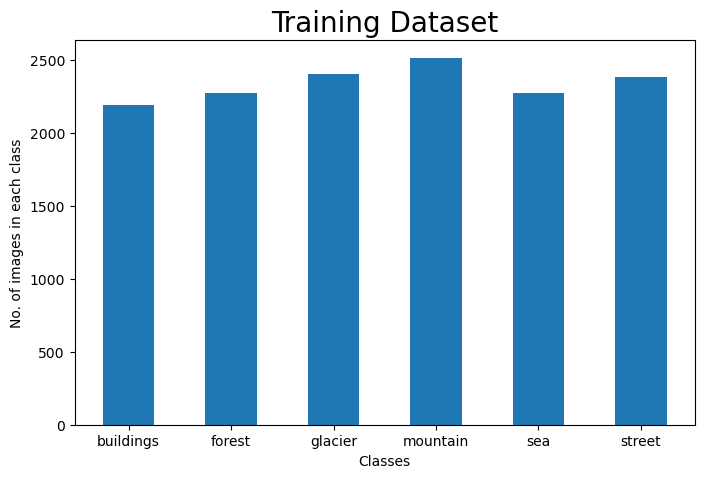

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(class_names, NoClsImgs, width=0.5)
plt.xlabel('Classes')
plt.ylabel('No. of images in each class')
plt.title('Training Dataset', fontsize=20)
plt.show()

In [ ]:
#Vérifiez maintenant la forme des images
size = []
for folder in os.listdir(trainpath):
    files = gb.glob(pathname=str(os.path.join(trainpath, folder) + '/*.jpg'))
    for file in files:
        image = cv2.imread(file)
        size.append(image.shape)

print(pd.Series(size).value_counts())

#150: La hauteur de l'image en pixels.
#150: La largeur de l'image en pixels.
#3: Le nombre de canaux de couleur de l'image. Dans ce cas, 3 indique que
#l'image utilise la représentation des couleurs RGB (Rouge, Vert, Bleu).


(150, 150, 3)    13986
(113, 150, 3)        7
(111, 150, 3)        3
(135, 150, 3)        3
(144, 150, 3)        2
(123, 150, 3)        2
(142, 150, 3)        2
(146, 150, 3)        2
(143, 150, 3)        2
(134, 150, 3)        2
(136, 150, 3)        2
(108, 150, 3)        2
(105, 150, 3)        1
(97, 150, 3)         1
(131, 150, 3)        1
(147, 150, 3)        1
(81, 150, 3)         1
(145, 150, 3)        1
(141, 150, 3)        1
(100, 150, 3)        1
(103, 150, 3)        1
(76, 150, 3)         1
(120, 150, 3)        1
(102, 150, 3)        1
(119, 150, 3)        1
(133, 150, 3)        1
(115, 150, 3)        1
(124, 150, 3)        1
(110, 150, 3)        1
(149, 150, 3)        1
(140, 150, 3)        1
dtype: int64


In [ ]:
#Test Data
#vérifier le nombre d'images dans chaque dossier dans les données de test
NoTsImgs = 0
NoClsImgs = []
for folder in os.listdir(testpath):
    images = len([i for i in os.listdir(os.path.join(testpath, folder)) if i.endswith('.jpg')])
    NoClsImgs.append(images)
    print(f'For test data, found {images} in folder {folder}')
    NoTsImgs += images

For test data, found 437 in folder buildings
For test data, found 474 in folder forest
For test data, found 553 in folder glacier
For test data, found 525 in folder mountain
For test data, found 510 in folder sea
For test data, found 501 in folder street


In [ ]:
print(f'The number of images in test data is: {NoTsImgs}')

The number of images in test data is: 3000


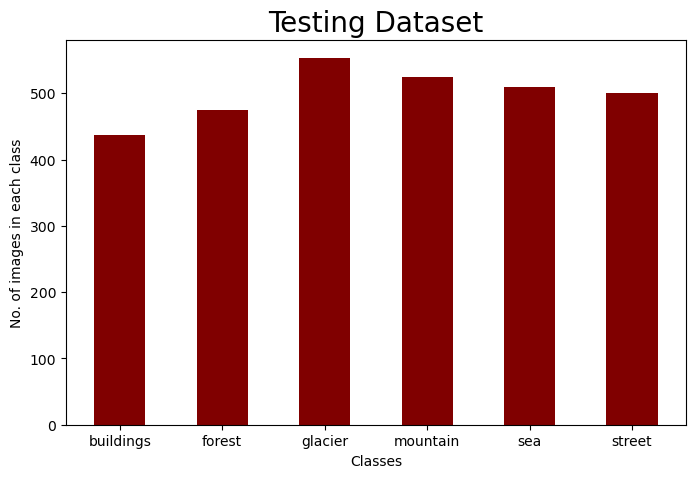

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(class_names, NoClsImgs, width=0.5, color='maroon')
plt.xlabel('Classes')
plt.ylabel('No. of images in each class')
plt.title('Testing Dataset', fontsize=20)
plt.show()

In [ ]:
#Vérifiez maintenant la forme des images
size = []
for folder in os.listdir(testpath):
    files = gb.glob(pathname=str(os.path.join(testpath, folder) + '/*.jpg'))
    for file in files:
        image = cv2.imread(file)
        size.append(image.shape)

print(pd.Series(size).value_counts())

(150, 150, 3)    2993
(141, 150, 3)       1
(110, 150, 3)       1
(76, 150, 3)        1
(149, 150, 3)       1
(72, 150, 3)        1
(131, 150, 3)       1
(81, 150, 3)        1
dtype: int64


In [ ]:
#Prétraitement des données
#nous l'utiliserons pour remodeler les images
s = 100

In [ ]:
class_names_label = {class_names:i for i, class_names in enumerate(class_names)}
class_names_label

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [ ]:
#cette fonction renverra le nom de la classe en lui donnant un numéro de 0 à 5
def get_label(n):
    for key, value in class_names_label.items():
        if n == value:
            return key

In [ ]:
#lire toutes les images des données d'entraînement et les étiqueter
X_train = []
y_train = []

for folder in os.listdir(trainpath):
    files = gb.glob(pathname=str(os.path.join(trainpath, folder) + '/*.jpg'))
    for file in files:
        image = cv2.imread(file)
        image_array = cv2.resize(image, (s, s))
        X_train.append(list(image_array))
        y_train.append(class_names_label[folder])

print(len(X_train))

14034


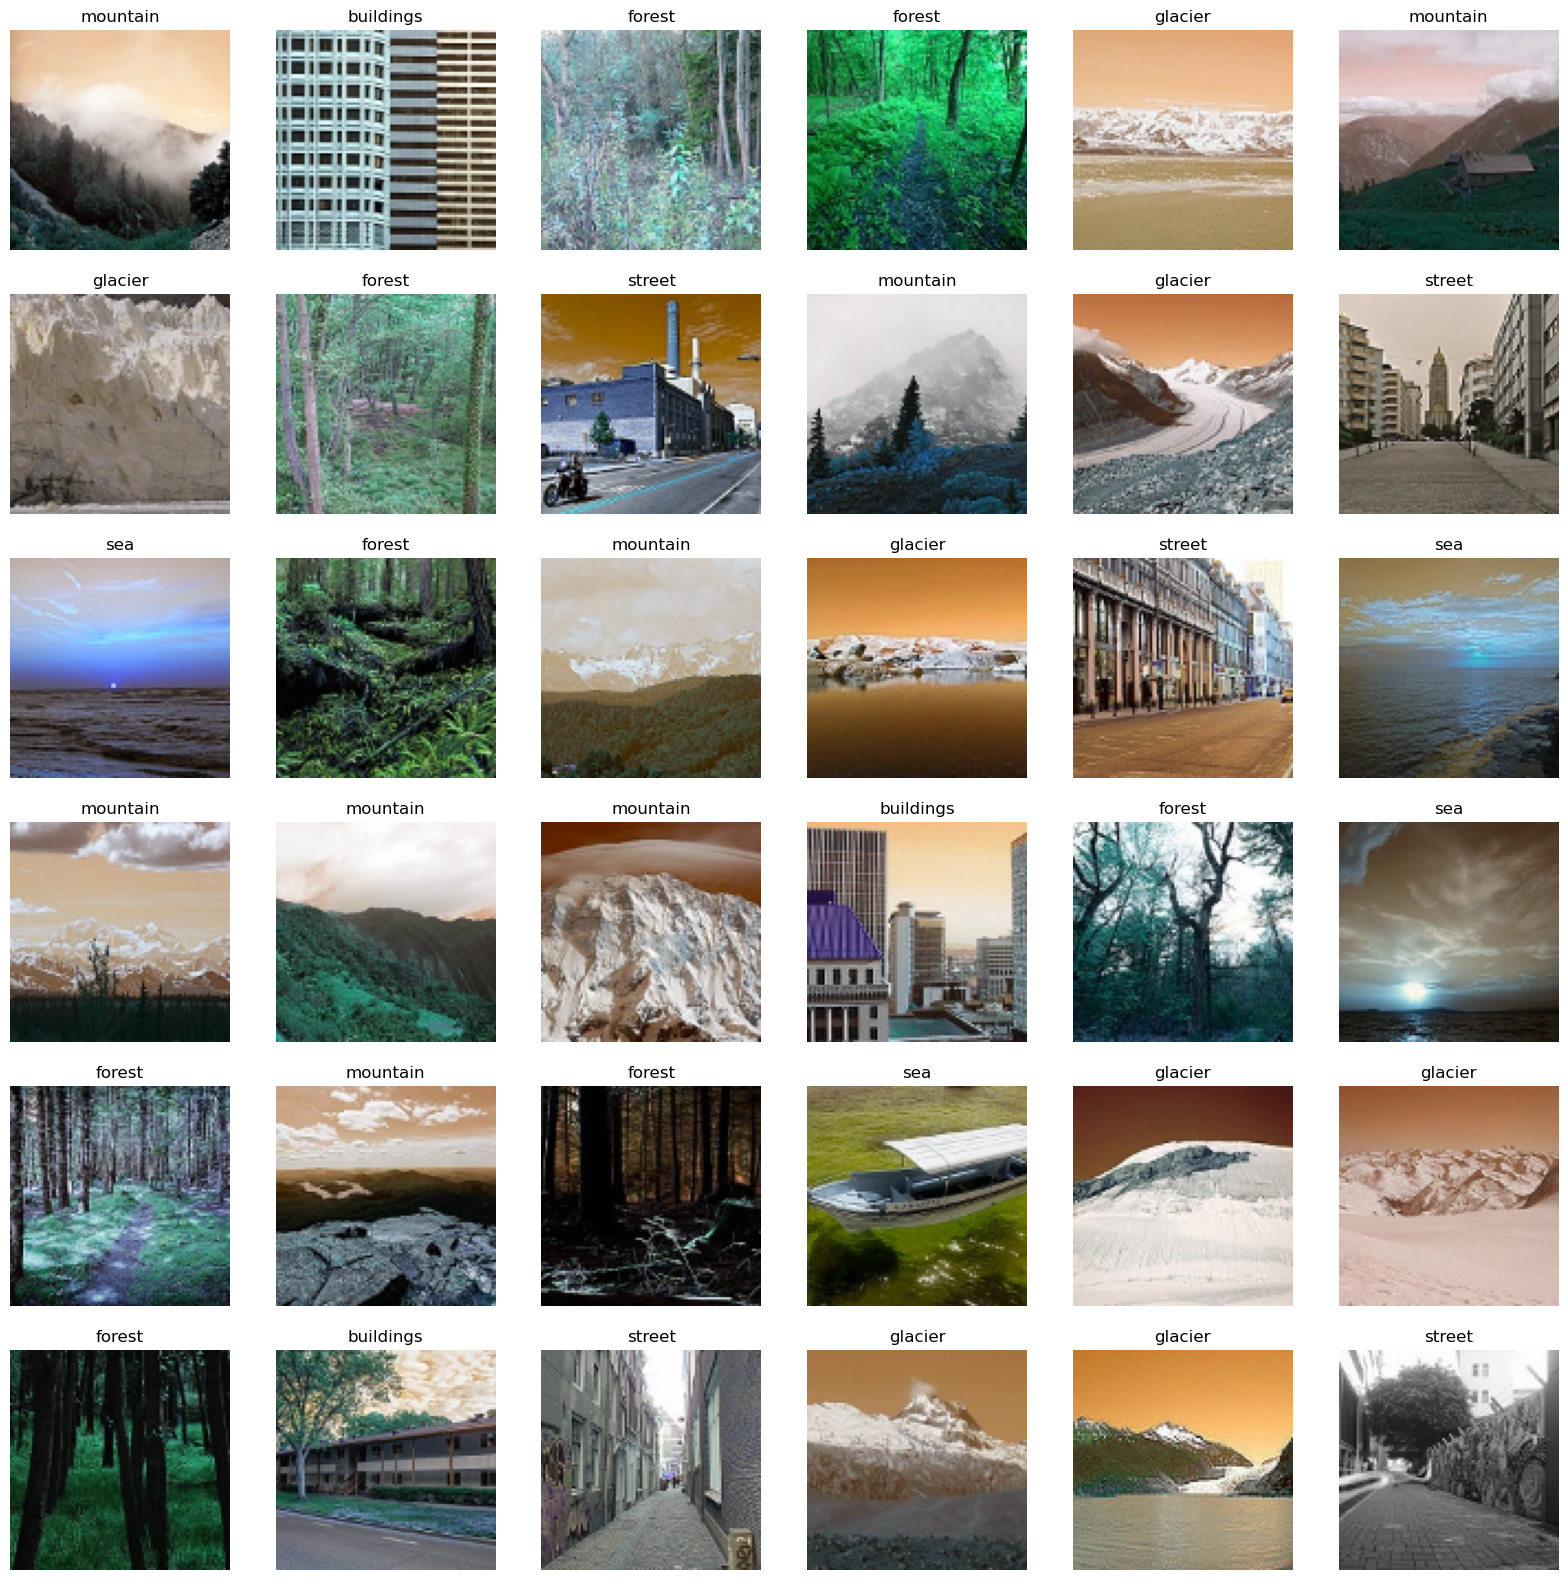

In [ ]:
#Montrons quelques images aléatoires dans les données du train
plt.figure(figsize=(20, 20))
for n, i in enumerate(list(np.random.randint(0, len(X_train), 36))):
    plt.subplot(6, 6, n+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title(get_label(y_train[i]))

In [ ]:
#lisez toutes les images des données de test et étiquetez-les

X_test = []
y_test = []

for folder in os.listdir(testpath):
    files = gb.glob(pathname=str(os.path.join(testpath, folder) + '/*.jpg'))
    for file in files:
        image = cv2.imread(file)
        image_array = cv2.resize(image, (s, s))
        X_test.append(list(image_array))
        y_test.append(class_names_label[folder])

print(len(X_test))

3000


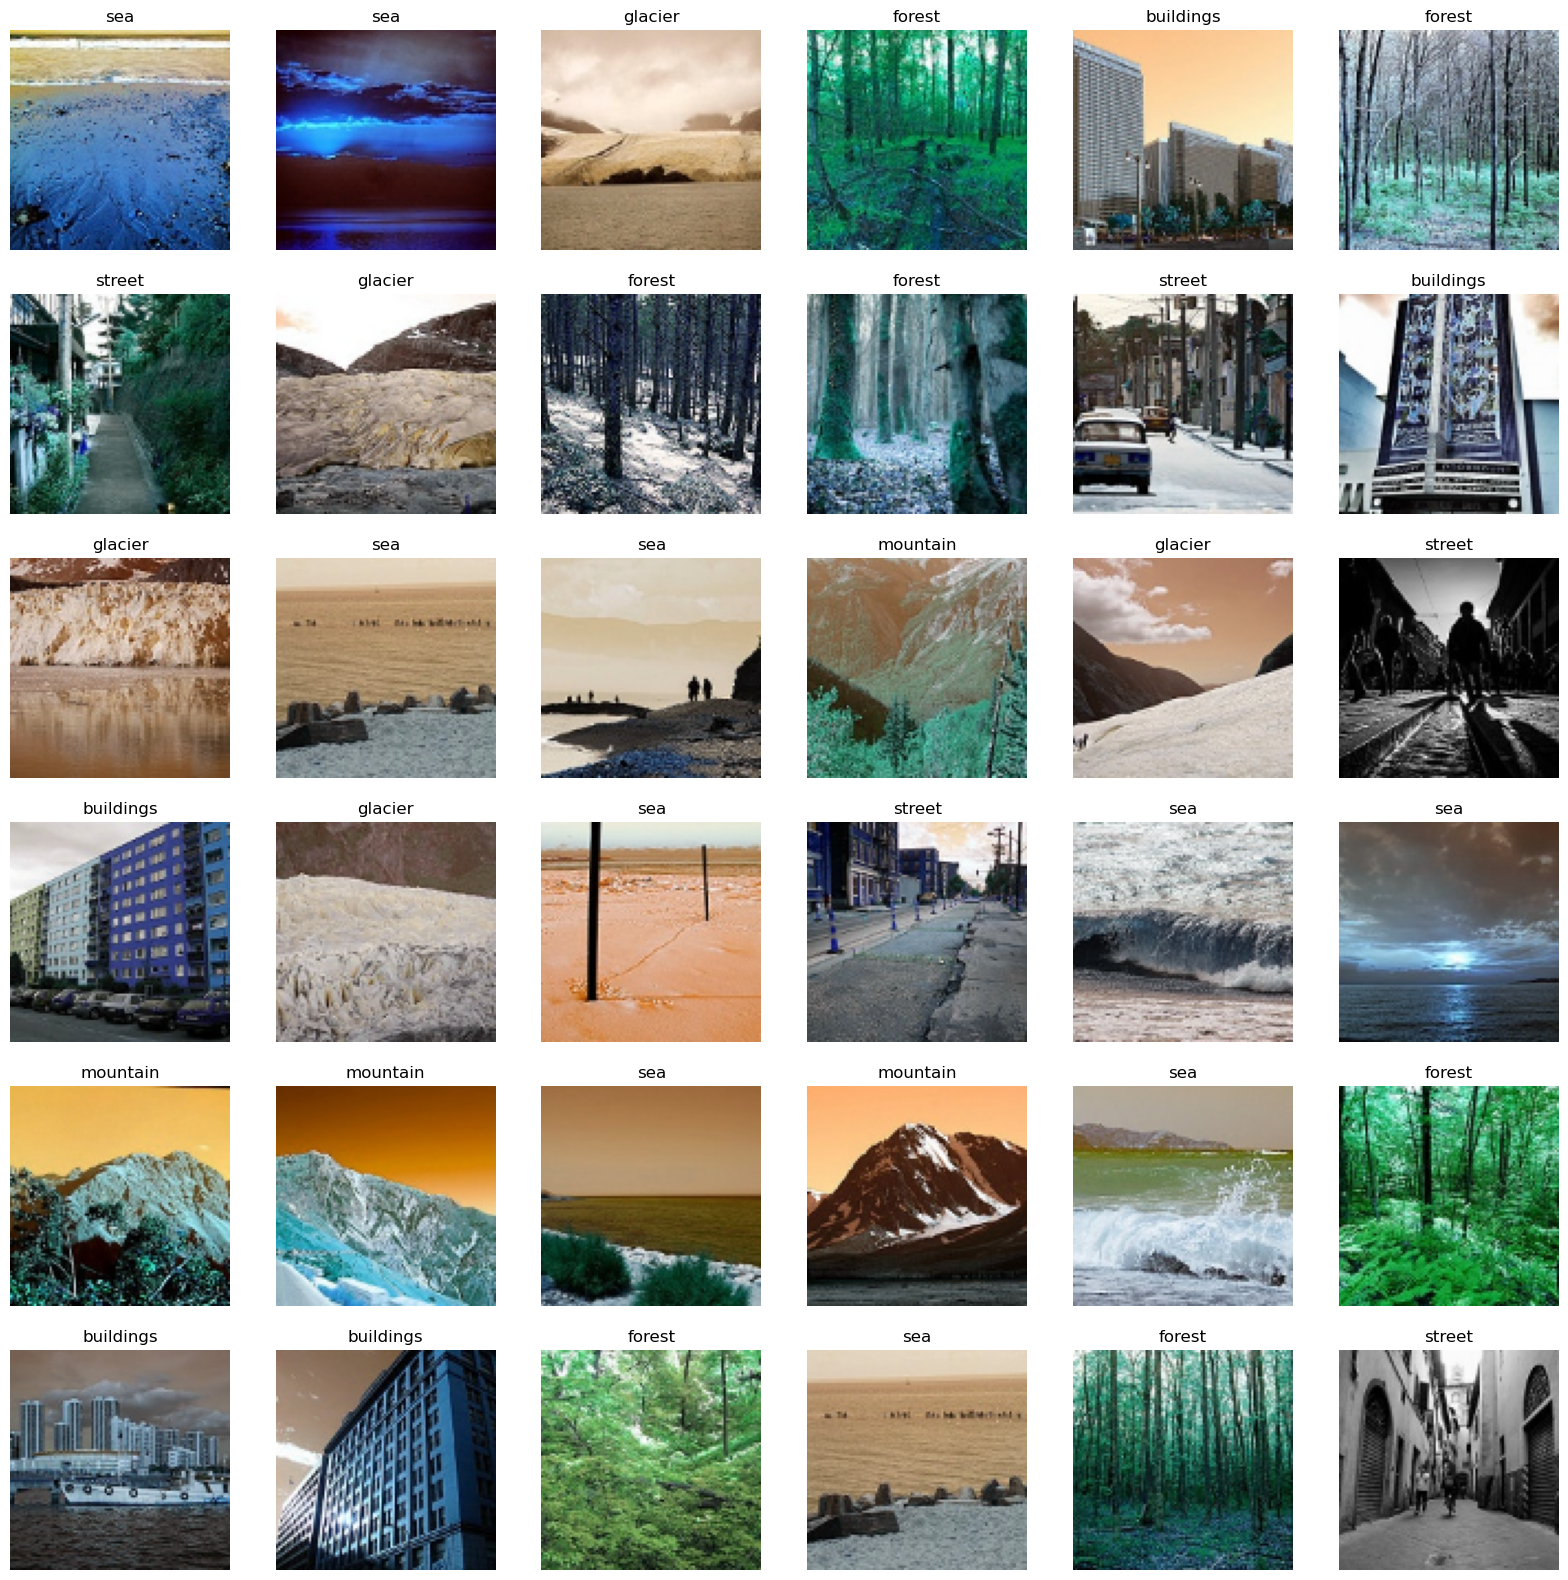

In [ ]:
# Montrons quelques images aléatoires dans X_test

plt.figure(figsize=(20, 20))
for n, i in enumerate(list(np.random.randint(0, len(X_test), 36))): # n -> index , i -> random numbers
    plt.subplot(6, 6, n+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(get_label(y_test[i]))

In [ ]:
#Convertissez les données en tableaux en utilisant numpy
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
print(f'X_train shape  is {X_train.shape}')
print(f'X_test shape  is {X_test.shape}')
print(f'y_train shape  is {y_train.shape}')
print(f'y_test shape  is {y_test.shape}')

X_train shape  is (14034, 100, 100, 3)
X_test shape  is (3000, 100, 100, 3)
y_train shape  is (14034,)
y_test shape  is (3000,)


In [ ]:
#Mise à l'échelle des données
X_train = X_train / 255
X_test = X_test / 255
#En divisant toutes les valeurs par 255,normalises les intensités des pixels pour qu'elles soient dans la plage [0, 1].
#cela peut aider à améliorer la convergence du modèle et à éviter des problèmes numériques.

In [ ]:
# Construire le modèle
# Construisez maintenant le modèle CNN par Keras, en utilisant les couches Conv2D, MaxPooling et Denses.
CNN_model = Sequential()
# Cette couche convolutive applique des filtres pour extraire des caractéristiques importantes de l'image
CNN_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(s, s, 3)))
CNN_model.add(MaxPooling2D())
# Pooling: Cette couche réduit les dimensions spatiales de la sortie
# de la couche précédente en conservant les informations les plus importantes.
CNN_model.add(Conv2D(32, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D())

CNN_model.add(Conv2D(16, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D())

CNN_model.add(Flatten())
# Dense: sont utilisées pour la classification.
CNN_model.add(Dense(128, activation='relu'))
CNN_model.add(Dense(6, activation='softmax'))


In [ ]:
#maintenant pour compiler le modèle, en utilisant l'optimiseur Adam et une perte d'entropie croisée catégorielle clairsemée .
CNN_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [ ]:
# Afficher quelques détails sur le modèle
CNN_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 10, 10, 16)       

In [ ]:
#Train the model
EPOCHS = 5
history = CNN_model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test))

Epoch 1/5


439/439 [==============================] - 69s 149ms/step - loss: 1.0618 - accuracy: 0.5871 - val_loss: 0.8636 - val_accuracy: 0.6763
Epoch 2/5
439/439 [==============================] - 60s 138ms/step - loss: 0.7780 - accuracy: 0.7113 - val_loss: 0.7079 - val_accuracy: 0.7430
Epoch 3/5
439/439 [==============================] - 54s 124ms/step - loss: 0.6404 - accuracy: 0.7666 - val_loss: 0.5906 - val_accuracy: 0.7883
Epoch 4/5
439/439 [==============================] - 61s 138ms/step - loss: 0.5486 - accuracy: 0.7989 - val_loss: 0.5518 - val_accuracy: 0.7987
Epoch 5/5
439/439 [==============================] - 58s 133ms/step - loss: 0.4854 - accuracy: 0.8221 - val_loss: 0.5558 - val_accuracy: 0.7993


In [ ]:
EPOCHS = 10
history = CNN_model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test))

Epoch 1/10
439/439 [==============================] - 64s 143ms/step - loss: 0.4286 - accuracy: 0.8452 - val_loss: 0.5710 - val_accuracy: 0.7910
Epoch 2/10
439/439 [==============================] - 60s 137ms/step - loss: 0.3792 - accuracy: 0.8611 - val_loss: 0.5876 - val_accuracy: 0.7957
Epoch 3/10
439/439 [==============================] - 58s 132ms/step - loss: 0.3183 - accuracy: 0.8847 - val_loss: 0.6025 - val_accuracy: 0.7923
Epoch 4/10
439/439 [==============================] - 58s 132ms/step - loss: 0.2721 - accuracy: 0.9007 - val_loss: 0.6310 - val_accuracy: 0.8007
Epoch 5/10
439/439 [==============================] - 58s 132ms/step - loss: 0.2316 - accuracy: 0.9173 - val_loss: 0.6929 - val_accuracy: 0.8043
Epoch 6/10
439/439 [==============================] - 58s 131ms/step - loss: 0.2035 - accuracy: 0.9274 - val_loss: 0.7485 - val_accuracy: 0.7930
Epoch 7/10
439/439 [==============================] - 63s 143ms/step - loss: 0.1605 - accuracy: 0.9439 - val_loss: 0.7518 - val_ac

In [ ]:
EPOCHS = 30
history = CNN_model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test))

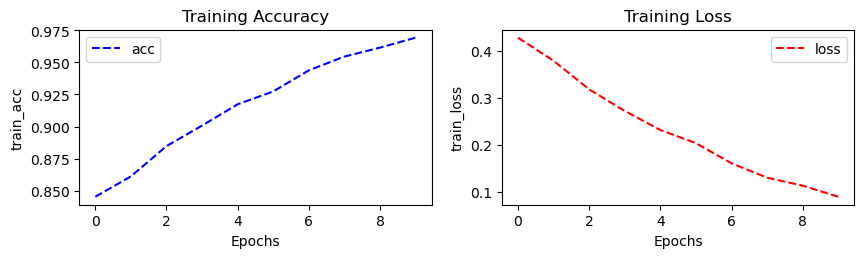

In [ ]:
# Plot the accuracy and loss during the training

fig = plt.figure(figsize=(10, 5))

plt.subplot(221)
plt.plot(history.history['accuracy'], 'b--', label='acc')
plt.xlabel('Epochs')
plt.ylabel('train_acc')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(222)
plt.plot(history.history['loss'], 'r--', label='loss')
plt.xlabel('Epochs')
plt.ylabel('train_loss')
plt.title('Training Loss')
plt.legend()

plt.show()

In [ ]:
Loss, Accuracy = CNN_model.evaluate(X_test, y_test)
print('Loss = ', Loss)
print('Accuracy = ', Accuracy)

94/94 [==============================] - 2s 23ms/step - loss: 0.9244 - accuracy: 0.7980
Loss =  0.9243516325950623
Accuracy =  0.7979999780654907


In [ ]:
y_pred = CNN_model.predict(X_test)
y_pred.shape

94/94 [==============================] - 3s 23ms/step


(3000, 6)

94/94 [==============================] - 2s 25ms/step


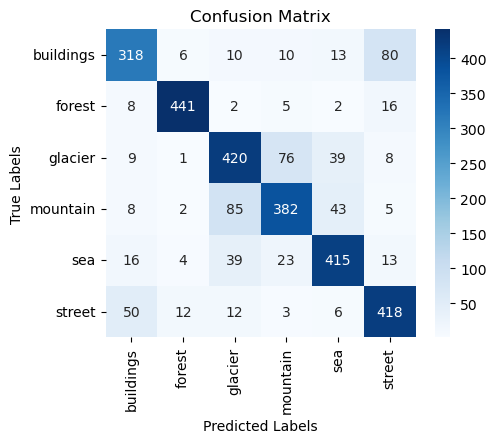

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obtiens les prédictions du modèle sur les données de test
y_pred = CNN_model.predict(X_test)

# Convertis les prédictions en classes prédites (indices des valeurs maximales)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Affiche la matrice de confusion sous forme de heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 1s 650ms/step


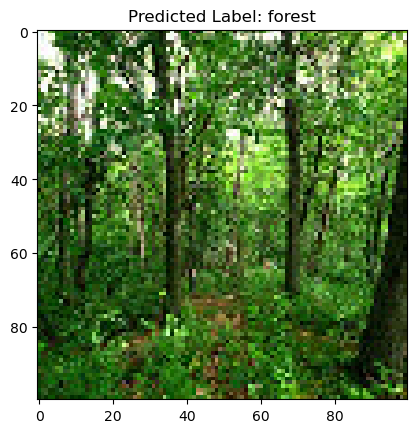

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

# Charger l'image à prédire
img_path = 'C:/Users/LENOVO/Desktop/intel/archive (4)/seg_test/seg_test/forest/20315.jpg'
img = image.load_img(img_path, target_size=(s, s))

# Convertir l'image en tableau Numpy
img_array = image.img_to_array(img)

# Ajouter une dimension supplémentaire pour créer un lot (batch) d'une seule image
img_array = np.expand_dims(img_array, axis=0)

# Normaliser l'image comme tu l'as fait pour les données d'entraînement
img_array = img_array / 255.0

# Obtenir la prédiction du modèle
prediction = CNN_model.predict(img_array)

# Convertir la prédiction en label
predicted_label = get_label(np.argmax(prediction))

# Afficher l'image et la prédiction
plt.imshow(img)
plt.title(f'Predicted Label: {predicted_label}')
plt.show()
